In [27]:
import numpy as np
import pandas as pd
import missingno as msno
import seaborn as sns
import warnings
import nltk
import gensim
import cufflinks as cf
import plotly.graph_objs as go
import warnings

from matplotlib import pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from gensim import corpora
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

%matplotlib inline
init_notebook_mode(connected = True)
warnings.filterwarnings("ignore",category=plt.cbook.mplDeprecation)

In [28]:
# load data
data = pd.read_csv('data/fr.openfoodfacts.org.products.csv', sep='\t', low_memory=False)
print(data.shape)
data.head(3)

(320772, 162)


,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,0000000003087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,0000000004559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN


### Mon idée : regrouper les aliments selon différents besoins des personnes (ex. high protein foods, high fat foods, high suger foods, high energy foods, diabetes frendly foods,  high-calorie, average-calorie and low-calorie food, etc.)
### Choix des variables pertinents pour mon idéé de l'appication
les variables seront choisi en fonction de mon idée et leur taux de remplissage (>25%)

<AxesSubplot:xlabel='Taux', ylabel='Variable'>

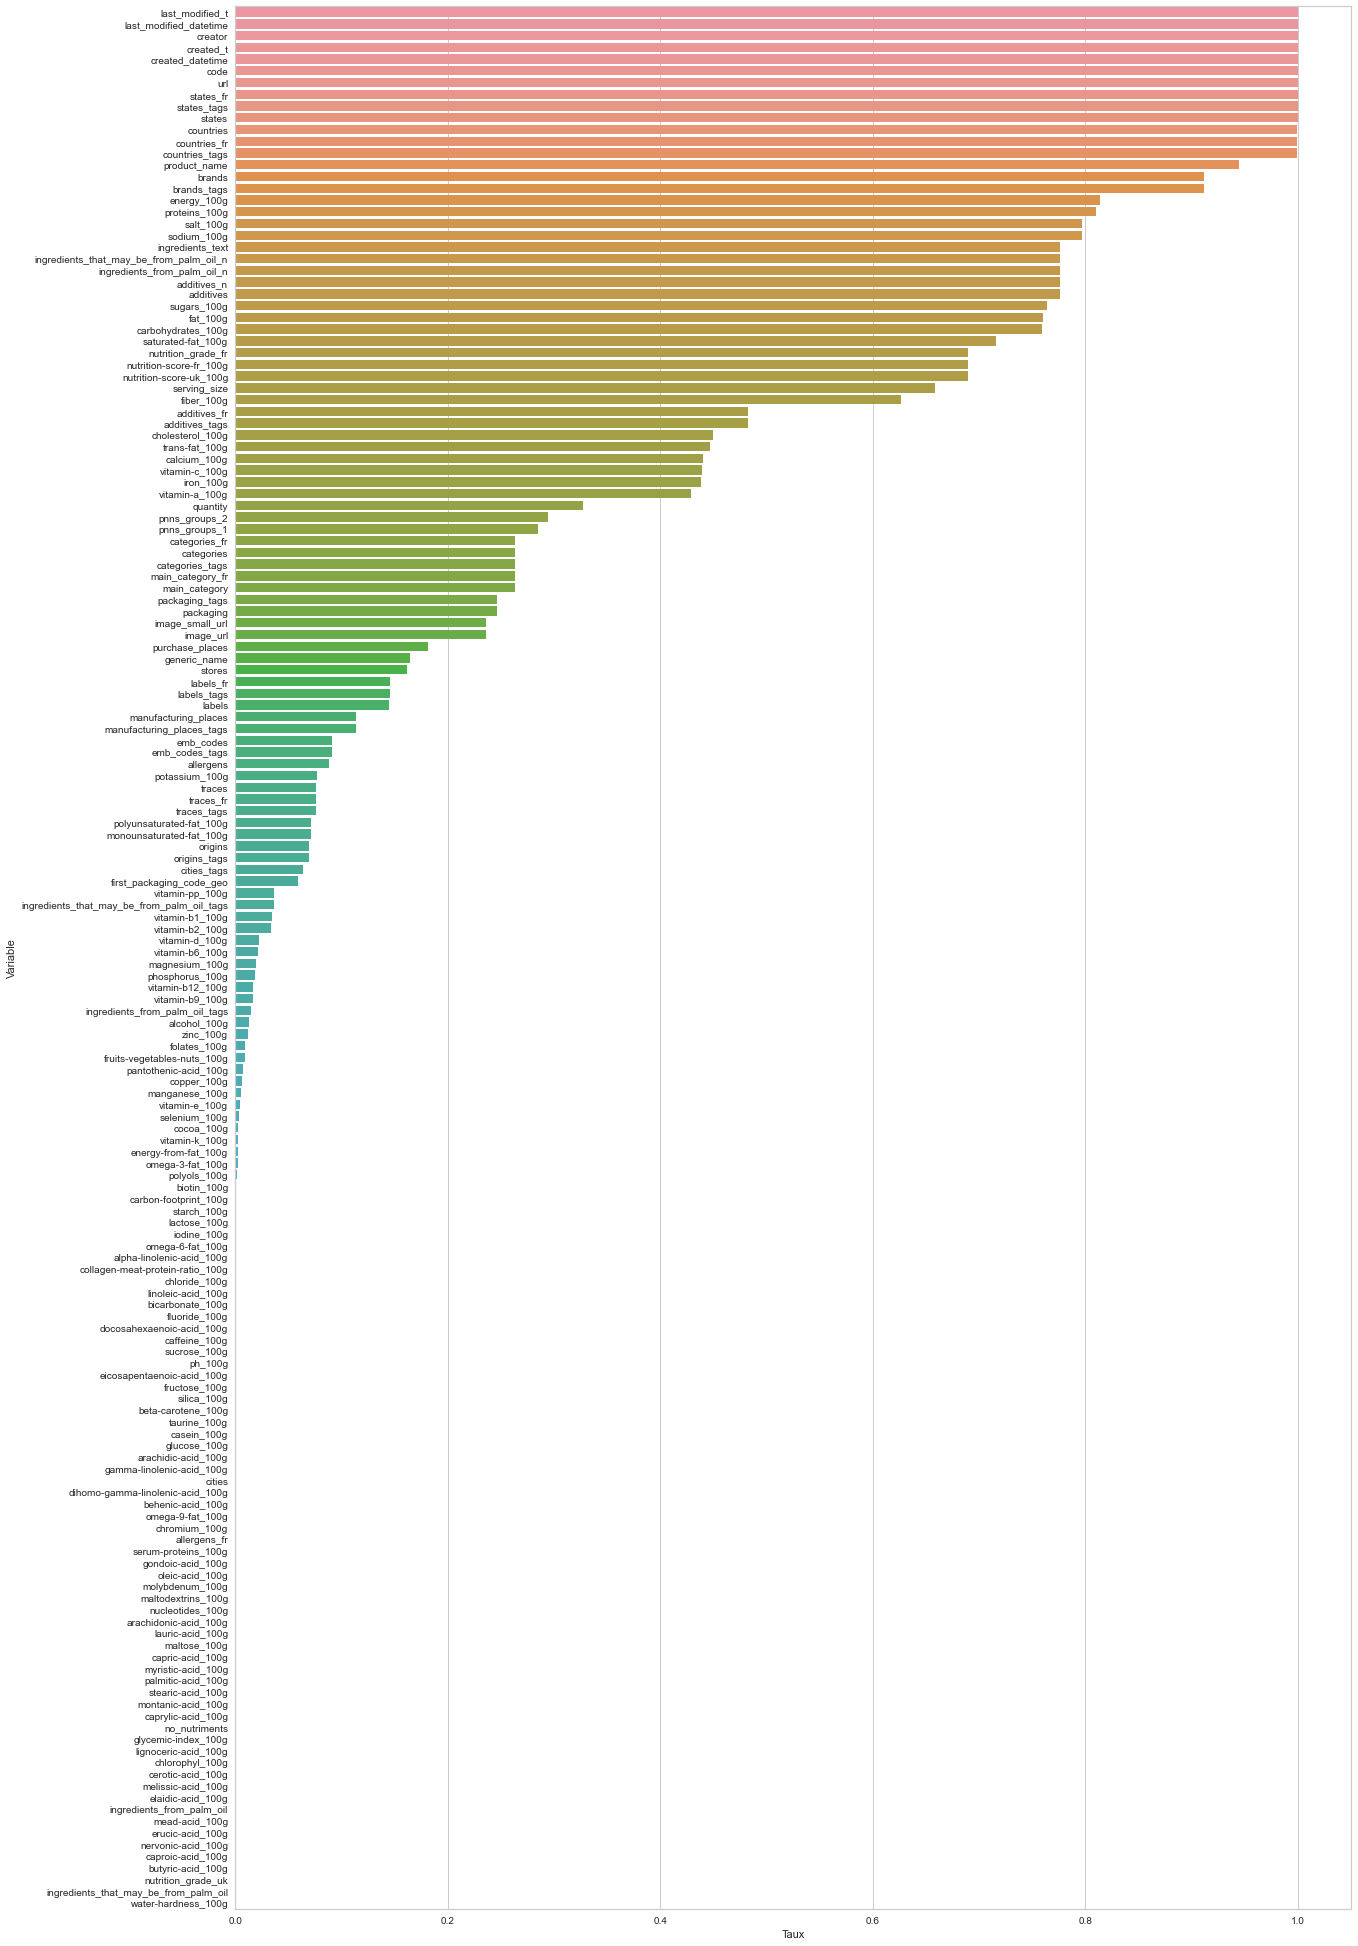

In [29]:
taux_remplissage = 1 - data.isnull().sum() / len(data)
tableau_taux = taux_remplissage.sort_values(ascending = False).reset_index()
tableau_taux.columns = ['Variable', 'Taux']
fig = plt.figure(figsize=(20, 35))
sns.barplot(x="Taux", y="Variable", data=tableau_taux)

In [30]:
# choirir les variable qui ont un taux de remplissage > 25 % et aui sont pertinents pour mon application
variables_pertinant = tableau_taux.loc[tableau_taux['Taux'] > 0.25]
variables_pertinant

,Variable,Taux
0,last_modified_t,1.000000
1,last_modified_datetime,1.000000
2,creator,0.999994
3,created_t,0.999991
4,created_datetime,0.999972
5,code,0.999928
6,url,0.999928
7,states_fr,0.999857
8,states_tags,0.999857
9,states,0.999857


les variables pertinentes et bien remplies pour cette application sont : 'product_name', 'energy_100g', 'proteins_100g', 'salt_100g', 'sugars_100g', 'fat_100g', 'carbohydrates_100g', 'nutrition-score-fr_100g','nutrition_grade_fr'

In [31]:
new_data = data[['product_name', 'energy_100g','proteins_100g','salt_100g','sugars_100g','fat_100g','carbohydrates_100g', 'fiber_100g', 'saturated-fat_100g', 'sodium_100g', 'nutrition-score-fr_100g','nutrition_grade_fr']]
new_data.head(3)

,product_name,energy_100g,proteins_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,fiber_100g,saturated-fat_100g,sodium_100g,nutrition-score-fr_100g,nutrition_grade_fr
0,Farine de blé noir,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Banana Chips Sweetened (Whole),2243.0,3.57,0.000,14.29,28.57,64.29,3.6,28.57,0.00,14.0,d
2,Peanuts,1941.0,17.86,0.635,17.86,17.86,60.71,7.1,0.00,0.25,0.0,b


### Nettoyage des données (valeurs manquantes, valeurs aberrantes etc.)

In [32]:
# Si on regarde les valeurs Max et Min, on voit qu'il y a surement des valeurs abberrantes.
new_data.describe()

,energy_100g,proteins_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,fiber_100g,saturated-fat_100g,sodium_100g,nutrition-score-fr_100g
count,2.611130e+05,259922.000000,255510.000000,244971.000000,243891.000000,243588.000000,200886.000000,229554.000000,255463.000000,221210.000000
mean,1.141915e+03,7.075940,2.028624,16.003484,12.730379,32.073981,2.862111,5.129932,0.798815,9.165535
std,6.447154e+03,8.409054,128.269454,22.327284,17.578747,29.731719,12.867578,8.014238,50.504428,9.055903
min,0.000000e+00,-800.000000,0.000000,-17.860000,0.000000,0.000000,-6.700000,0.000000,0.000000,-15.000000
25%,3.770000e+02,0.700000,0.063500,1.300000,0.000000,6.000000,0.000000,0.000000,0.025000,1.000000
50%,1.100000e+03,4.760000,0.581660,5.710000,5.000000,20.600000,1.500000,1.790000,0.229000,10.000000
75%,1.674000e+03,10.000000,1.374140,24.000000,20.000000,58.330000,3.600000,7.140000,0.541000,16.000000
max,3.251373e+06,430.000000,64312.800000,3520.000000,714.290000,2916.670000,5380.000000,550.000000,25320.000000,40.000000


In [33]:
# supprimer les produits qui ne ppssèdent pas le 'product_name' car ils ne peuvent pas être identifiés.
new_data = new_data.loc[~new_data['product_name'].isnull(), :]

Je supprime tout d'abord les produits qui ne présente aucunes valeurs pour ces colonnes: [energy_100g] [proteins_100g] [salt_100g] ,[sugars_100g], [fat_100g],[carbohydrates_100g], [fiber_100g], [saturated-fat_100g], [sodium_100g]

In [34]:
new_data.dropna(axis=0, how='all', subset=['energy_100g','proteins_100g','salt_100g','sugars_100g','fat_100g','carbohydrates_100g', 'fiber_100g', 'saturated-fat_100g', 'sodium_100g'], inplace=True)

#### Valeurs abberantes 
pour les colonnes [energy_100g] [proteins_100g] [salt_100g] ,[sugars_100g], [fat_100g],[carbohydrates_100g], [fiber_100g], [saturated-fat_100g], [sodium_100g] <100g

In [35]:
new_data = new_data[~(new_data[list(new_data.columns)[2:9]] > 100).any(axis=1)]
new_data = new_data[~(new_data[list(new_data.columns)[2:9]] < 0).any(axis=1)]

In [36]:
# 
new_data = new_data[~((new_data['saturated-fat_100g'] > new_data['fat_100g']) 
                                | (new_data['sodium_100g'] > new_data['salt_100g']))]

In [37]:
# Energy max = Energy of Lipides = 37 (kJ/g) 
# https://fr.wikipedia.org/wiki/Valeur_%C3%A9nerg%C3%A9tique
new_data_cleaned = new_data.loc[new_data['energy_100g'] <= 3700]

In [38]:
new_data_cleaned.describe()

,energy_100g,proteins_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,fiber_100g,saturated-fat_100g,sodium_100g,nutrition-score-fr_100g
count,256637.000000,255060.000000,250762.000000,240768.000000,238542.000000,238691.000000,197479.000000,225255.000000,250735.000000,217472.000000
mean,1118.274987,7.090972,1.591976,15.974231,12.551358,32.127377,2.835637,5.045082,0.626828,9.135774
std,787.874034,8.157099,6.233423,21.154384,17.167683,29.154966,4.586617,7.680112,2.454219,9.047950
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.000000
25%,372.000000,0.700000,0.063500,1.320000,0.000000,6.000000,0.000000,0.000000,0.025000,1.000000
50%,1100.000000,4.760000,0.589280,5.710000,5.000000,20.780000,1.500000,1.790000,0.232000,10.000000
75%,1674.000000,10.000000,1.379220,24.000000,20.000000,58.500000,3.600000,7.140000,0.543000,16.000000
max,3700.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,39.370079,40.000000


In [39]:
# Je veux savoir il rests combien de valeurs manquantes dans dataframe après éliminer les valeurs abberrants.
new_data_cleaned[['product_name', 'energy_100g', 'proteins_100g', 'salt_100g', 'sugars_100g', 'fat_100g', 'carbohydrates_100g']].isnull().sum()

product_name              0
energy_100g               0
proteins_100g          1577
salt_100g              5875
sugars_100g           15869
fat_100g              18095
carbohydrates_100g    17946
dtype: int64

#### Imputation des valeurs maquantes

In [40]:
# Knn imputer pour remplir les NaN par 
from sklearn.impute import KNNImputer
def imputation_NaN(colonnes):
    y_missing = new_data_cleaned[[colonnes]]
    imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
    new_data_proteinsfilld = imputer.fit_transform(y_missing)
    new_data_cleaned[colonnes] = new_data_proteinsfilld.reshape(-1)

In [41]:
imputation_NaN('proteins_100g')
imputation_NaN('salt_100g')
imputation_NaN('sugars_100g')
imputation_NaN('fat_100g')
imputation_NaN('carbohydrates_100g')

In [42]:
# on vérifie qu'il n'y pas de valeurs manquantes
new_data_cleaned[['energy_100g', 'proteins_100g', 'salt_100g', 'sugars_100g', 'fat_100g', 'carbohydrates_100g']].isnull().sum()

energy_100g           0
proteins_100g         0
salt_100g             0
sugars_100g           0
fat_100g              0
carbohydrates_100g    0
dtype: int64

In [43]:
new_data_cleaned.head(3)

,product_name,energy_100g,proteins_100g,salt_100g,sugars_100g,fat_100g,carbohydrates_100g,fiber_100g,saturated-fat_100g,sodium_100g,nutrition-score-fr_100g,nutrition_grade_fr
1,Banana Chips Sweetened (Whole),2243.0,3.57,0.00000,14.29,28.57,64.29,3.6,28.57,0.000,14.0,d
2,Peanuts,1941.0,17.86,0.63500,17.86,17.86,60.71,7.1,0.00,0.250,0.0,b
3,Organic Salted Nut Mix,2540.0,17.86,1.22428,3.57,57.14,17.86,7.1,5.36,0.482,12.0,d


In [44]:
# sauvgarder le dataframe pour l'analyse ultérieur
import joblib

joblib.dump(new_data_cleaned, 'data/new_data_cleaned.joblib')

['data/new_data_cleaned.joblib']